In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.utils.data
import torch.nn.parallel
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from tqdm import tqdm
import random

In [3]:
# Decide which device we want to run on
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


* **Getting the train and test dataset**

In [22]:
BATCH_SIZE = 1

# Define the Transform class
class Transform():
    def __init__(self):
        self.data_transform = transforms.Compose([transforms.ToTensor()])

    def __call__(self, inp):
        return self.data_transform(inp)

# Define the SeismicDataset class
class SeismicDataset(Dataset):
    def __init__(self, data_patches):
        self.data_patches = data_patches
        self.trasformer = Transform()

    def __len__(self):
        return len(self.data_patches)

    def __getitem__(self, idx):
        data_patch = self.data_patches[idx]
        data_patch = self.trasformer(data_patch)
        return data_patch

# Function to load binary data
def load_bin_data(file, samples):
    data = np.fromfile(file, dtype='float32')
    nrecs = data.size // samples
    data = data.reshape(nrecs, samples).T
    return data

def preprocess_patches(patches):
    # Normalize and add channel dimension for grayscale images
    max = abs(np.max(patches))
    min = abs(np.min(patches))
    maxi = np.max([max, min])
    patches = patches/maxi  # Normalize to [-1, 1]
    return patches[..., np.newaxis]  # Add channel dimension

# Function to split data into patches
def split_into_patches(data, patch_size=256, vertical_overlap=0, horizontal_overlap=0):
    step_h = patch_size - horizontal_overlap
    step_v = patch_size - vertical_overlap
    patches = []
    for i in range(0, data.shape[0] - patch_size + 1, step_v):
        for j in range(0, data.shape[1] - patch_size + 1, step_h):
            patch = data[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    return np.array(patches)

# Function to remove all-zero patches and maintain pairing
def remove_zero_and_same_value_patches(elastic_patches, acoustic_patches):
    paired_patches = []
    for e_patch, a_patch in zip(elastic_patches, acoustic_patches):
        if not np.all(e_patch <= 1e-4) and not np.all(a_patch <= 1e-4) and \
           len(np.unique(e_patch)) > 1 and len(np.unique(a_patch)) > 1:
            paired_patches.append((e_patch, a_patch))
    
    # Unzip the list of tuples back into separate arrays
    elastic_patches, acoustic_patches = zip(*paired_patches)
    return np.array(elastic_patches), np.array(acoustic_patches)

# Function to process folder
def process_folder(data_dir_elastic, data_dir_acoustic, idx_train, samples=768, patch_size=256):
    all_data_train_elastic = []
    all_data_test_elastic = []
    all_data_train_acoustic = []
    all_data_test_acoustic = []

    # Combine elasticdata and acousticdata based on idx_train
    for idx in range(1,362):
        elastic_file = f"Elasticdata{idx}.bin"
        if idx in idx_train:
            data = load_bin_data(os.path.join(data_dir_elastic, elastic_file), samples)
            all_data_train_elastic.append(data)
        else:
            data = load_bin_data(os.path.join(data_dir_elastic, elastic_file), samples)
            all_data_test_elastic.append(data)

    for idx in range(1,362):
        acoustic_file = f"Acusticdata{idx}.bin"
        if idx in idx_train:
            data = load_bin_data(os.path.join(data_dir_acoustic, acoustic_file), samples)
            all_data_train_acoustic.append(data)
        else:
            data = load_bin_data(os.path.join(data_dir_acoustic, acoustic_file), samples)
            all_data_test_acoustic.append(data)

    print(f'Train seismograms length : {len(all_data_train_elastic)}')
    print(f'Train seismograms length : {len(all_data_train_acoustic)}')

    return np.array(all_data_train_elastic), np.array(all_data_test_elastic), np.array(all_data_train_acoustic), np.array(all_data_test_acoustic)

# Paths to the directories
elastic_dir = r'C:\Users\Matheus\TrabalhodeMestrado\Redes Neurais\Dados\Seismic_data\Elastic_data\Pfield'
acoustic_dir = r'C:\Users\Matheus\TrabalhodeMestrado\Redes Neurais\Dados\Seismic_data\Acustic_data\Pfield'

# 80% of the files are used for training
n_train = 300
idx_train = np.sort(random.sample(range(1, 361), n_train))

# Load and separate data
train_elastic, test_elastic, train_acoustic, test_acoustic = process_folder(elastic_dir, acoustic_dir, idx_train)

# Split training data into patches
vertical_overlap = 128 # five vertical windowns
horizontal_overlap = 151 # two horizontal windowns
patch_size = 256
train_elastic_patches = np.concatenate([split_into_patches(data, patch_size, vertical_overlap, horizontal_overlap ) for data in train_elastic])
train_acoustic_patches = np.concatenate([split_into_patches(data, patch_size, vertical_overlap, horizontal_overlap ) for data in train_acoustic])

# Preprocess and create datasets
test_elastic_patches = preprocess_patches(test_elastic)
test_acoustic_patches = preprocess_patches(test_acoustic)
train_elastic_patches = preprocess_patches(train_elastic_patches)
train_acoustic_patches = preprocess_patches(train_acoustic_patches)

# # Remove zero patches and maintain pairing
# train_elastic_patches, train_acoustic_patches = remove_zero_and_same_value_patches(train_elastic_patches, train_acoustic_patches)
# test_elastic_patches, test_acoustic_patches = remove_zero_and_same_value_patches(test_elastic_patches, test_acoustic_patches)

# Create the dataset with paired data
test_elastic_patches = SeismicDataset(test_elastic_patches)
test_acoustic_patches = SeismicDataset(test_acoustic_patches)
train_elastic_patches = SeismicDataset(train_elastic_patches)
train_acoustic_patches = SeismicDataset(train_acoustic_patches)

# Criando o DataLoader de treino e teste
dataloader_elastic_test = DataLoader(test_elastic_patches, batch_size=BATCH_SIZE, shuffle=False)
dataloader_acoustic_test = DataLoader(test_acoustic_patches, batch_size=BATCH_SIZE, shuffle=False)
dataloader_elastic_train = DataLoader(train_elastic_patches, batch_size=BATCH_SIZE, shuffle=True)
dataloader_acoustic_train = DataLoader(train_acoustic_patches, batch_size=BATCH_SIZE, shuffle=True)

Train seismograms length : 300
Train seismograms length : 300


In [7]:
# Número de batches no DataLoader de treino
print(f"Número de batches: {len(dataloader_elastic_train)}")
print(f"Número de batches: {len(dataloader_acoustic_train)}")

# Número de batches no DataLoader de teste
print(f"Número de batches de teste: {len(dataloader_elastic_test)}")
print(f"Número de batches de teste: {len(dataloader_acoustic_test)}")

Número de batches: 3000
Número de batches: 3000
Número de batches de teste: 61
Número de batches de teste: 61


In [10]:
print(f'shape da saída do gerador {next(iter(dataloader_elastic_test)).shape}')
print(f'shape da saída do discriminador {next(iter(dataloader_elastic_test)).shape}')

shape da saída do gerador torch.Size([1, 1, 768, 361])
shape da saída do discriminador torch.Size([1, 1, 768, 361])


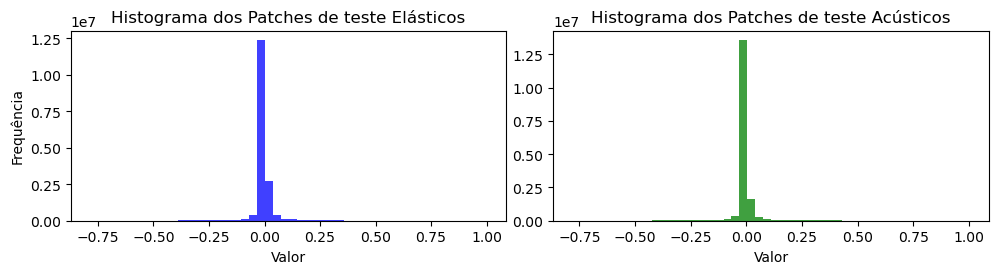

In [12]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for i, (elastic_patch, acoustic_patch) in enumerate(zip(dataloader_elastic_test, dataloader_acoustic_test)):
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de teste Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de teste Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

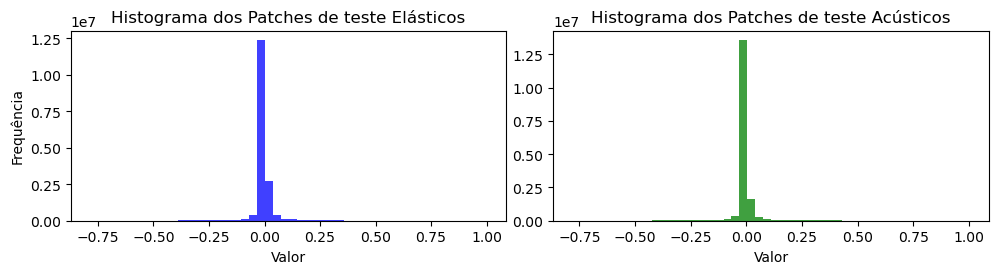

In [14]:
# Inicializar listas para armazenar os valores de todos os patches
all_elastic_values = []
all_acoustic_values = []

# Iterar sobre todo o DataLoader
for i, (elastic_patch, acoustic_patch) in enumerate(zip(dataloader_elastic_test, dataloader_acoustic_test)):
    all_elastic_values.append(elastic_patch.numpy().flatten())
    all_acoustic_values.append(acoustic_patch.numpy().flatten())

# Concatenar todos os valores de todos os patches em um único array
all_elastic_values = np.concatenate(all_elastic_values)
all_acoustic_values = np.concatenate(all_acoustic_values)

# Plotar o histograma para os patches elásticos e acústicos
plt.figure(figsize=(10, 3))

# Histograma para os patches elásticos
plt.subplot(1, 2, 1)
plt.hist(all_elastic_values, bins=50, alpha=0.75, color='blue')
plt.title('Histograma dos Patches de teste Elásticos')
plt.xlabel('Valor')
plt.ylabel('Frequência')

# Histograma para os patches acústicos
plt.subplot(1, 2, 2)
plt.hist(all_acoustic_values, bins=50, alpha=0.75, color='green')
plt.title('Histograma dos Patches de teste Acústicos')
plt.xlabel('Valor')

# Mostrar os gráficos
plt.tight_layout()
plt.show()

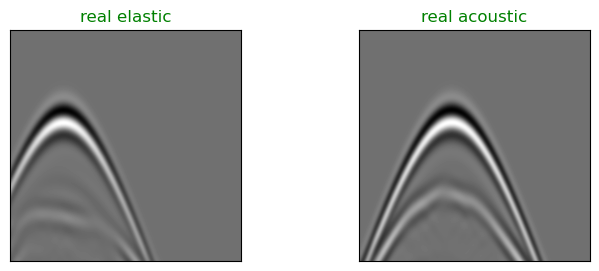

In [24]:
def show_img_sample(dataloader_elastic_train, dataloader_acoustic_train):
    for i, (real_elastic, real_acoustic) in enumerate(zip(dataloader_elastic_train, dataloader_acoustic_train)):
        if i > 0:
            break
        fig, axes = plt.subplots(1, 2, figsize=(9, 3))
        ax = axes.ravel()
        
        perc = 99
        vmax = np.percentile(np.abs(real_acoustic[0].squeeze()), perc)
        vmin = -vmax
        
        ax[0].imshow(real_elastic[0].squeeze(), cmap='gray')
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title("real elastic", c="g")
        ax[1].imshow(real_acoustic[0].squeeze(), cmap='gray')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title("real acoustic", c="g")
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

show_img_sample(dataloader_elastic_train, dataloader_acoustic_train)

* **Define the generator and discriminator**

In [26]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, in_channels, 3),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.BatchNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

In [28]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        
        # Inital Convolution  1*256*256 -> 64*256*256
        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, out_channels, 7),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
        channels = out_channels
        
        # Downsampling   64*256*256 -> 128*128*128 -> 256*64*64
        self.down = []
        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 7, stride=2, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)
        
        # Transformation (ResNet)  256*64*64
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)
        
        # Upsampling  256*64*64 -> 128*128*128 -> 64*256*256
        self.up = []
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)
        
        # Out layer  64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x

In [30]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # why normalize=False?
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32
            *self.block(256, 512), # 256*32*32 -> 512*16*16
            
            # Why padding first then convolution?
            nn.ZeroPad2d((1,0,1,0)), # padding left and top   512*16*16 -> 512*17*17
            nn.Conv2d(512, 1, 4, padding=1) # 512*17*17 -> 1*16*16
        )
        
        self.scale_factor = 16
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, x):
        return self.model(x)

* **Define the Loss**

In [33]:
# criterion_GAN = nn.BCEWithLogitsLoss() # Perda por entropia cruzada com uma função sigmoid
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

* **Inicializando os modelos na GPU**

In [36]:
G_AB = GeneratorResNet(1, num_residual_blocks=6)
D_B = Discriminator(1)

G_BA = GeneratorResNet(1, num_residual_blocks=6)
D_A = Discriminator(1)

In [38]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')

if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    
    criterion_GAN = criterion_GAN.cuda()
    criterion_cycle = criterion_cycle.cuda()
    criterion_identity = criterion_identity.cuda()

cuda: True


In [42]:
# Função para reverter a normalização [-1, 1] para [0, 1]
def denormalize(img):
    img = img * 0.5 + 0.5  # Reverte a normalização [-1, 1] para [0, 1]
    return img.clamp(0, 1)  # Garante que os valores estejam entre 0 e 1

# Defina Tensor de acordo com o dispositivo
def sample_images(real_A, real_B, G_AB, G_BA, title):
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'
    
    G_AB.eval()
    G_BA.eval()
    
    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()

    plt.figure(figsize=(8, 8))
    # Imagem original do domínio A (real_A) e sua tradução para o domínio B (fake_B)
    plt.subplot(2, 2, 1)
    plt.title("Real A (Entrada)")
    plt.imshow(denormalize(real_A[0]).squeeze().cpu().detach().numpy())
    
    plt.subplot(2, 2, 2)
    plt.title("Fake B (Gerado por G_AB)")
    plt.imshow(denormalize(fake_B[0]).squeeze().cpu().detach().numpy())

    # Imagem original do domínio B (real_B) e sua tradução para o domínio A (fake_A)
    plt.subplot(2, 2, 3)
    plt.title("Real B (Entrada)")
    plt.imshow(denormalize(real_B[0]).squeeze().cpu().detach().numpy())

    plt.subplot(2, 2, 4)
    plt.title("Fake A (Gerado por G_BA)")
    plt.imshow(denormalize(fake_A[0]).squeeze().cpu().detach().numpy())

    plt.savefig('Teste pós treino.png')
    plt.suptitle(title)
    plt.show()

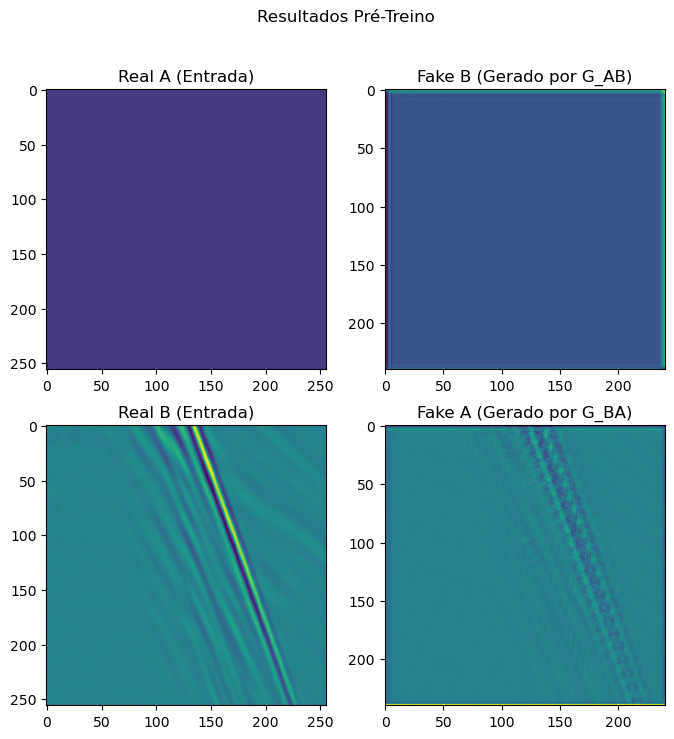

In [44]:
real_elastic = next(iter(dataloader_elastic_train))
real_acoustic = next(iter(dataloader_acoustic_train))
sample_images(real_acoustic, real_elastic, G_AB, G_BA, title='Resultados Pré-Treino')

* **Configurating de Optimizers**

In [46]:
import itertools

lr = 0.0002
b1 = 0.5
b2 = 0.999
LAMBDA_idt = 5
LAMBDA_cycle = 10

optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

* **Training step**

In [50]:
n_epoches = 100
decay_epoch = 90
G_losses, D_losses, identity_losses, GAN_losses, cycle_losses = [], [], [], [], []

# Function to decrease de learning rate util zero after epoch = 100
lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

for epoch in range(n_epoches):
    for i, (real_A, real_B) in enumerate(tqdm(zip(dataloader_acoustic_train, dataloader_elastic_train))):
        
        Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
        real_A, real_B = real_A[0].type(Tensor).to(device), real_B[0].type(Tensor).to(device)
    
        valid = torch.ones_like(D_A(real_A), device=device)
        fake = torch.zeros_like(D_A(real_A), device=device) 
        
        """Train Generators"""
        # set to training mode in the begining, because sample_images will set it to eval mode
        G_AB.train()
        G_BA.train()
        
        optimizer_G.zero_grad()
        
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        same_A = G_BA(real_A)
        same_B = G_AB(real_B)
        
        # identity loss
        loss_id_A = criterion_identity(same_A, real_A)
        loss_id_B = criterion_identity(same_B, real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss, train G to make D think it's true
        # The arguments True e False in criterionGAN() are equivalents to tensors torch.ones() e torch.zeros(), respectively
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) 
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # G total loss
        loss_G = LAMBDA_idt * loss_identidy + loss_GAN + LAMBDA_cycle * loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        """Train Discriminator A"""
        optimizer_D_A.zero_grad()
        
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        """Train Discriminator B"""
        optimizer_D_B.zero_grad()
        
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()
    
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Salvar as perdas para cada época
    G_losses.append(loss_G.item())
    D_losses.append((loss_D_A.item() + loss_D_B.item()) / 2)
    identity_losses.append(loss_identity.item())
    GAN_losses.append(loss_GAN.item())
    cycle_losses.append(loss_cycle.item())
    

    loss_D = (loss_D_A + loss_D_B) / 2
    print(f'[Epoch {epoch + 1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
    print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]')


0it [00:00, ?it/s]


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

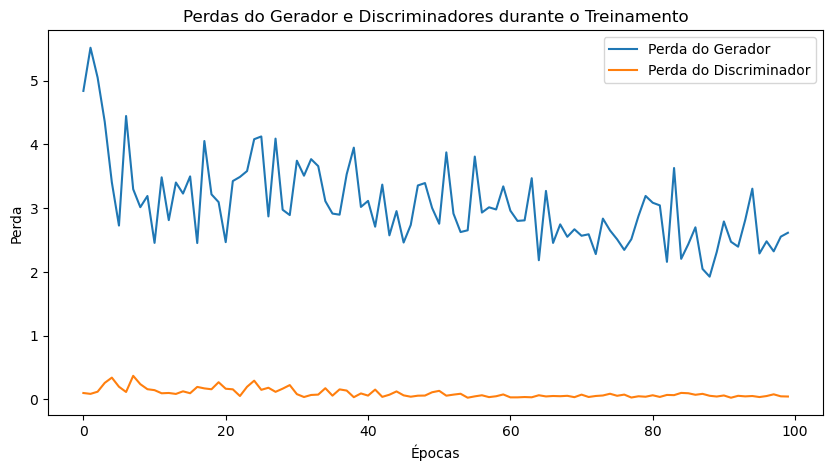

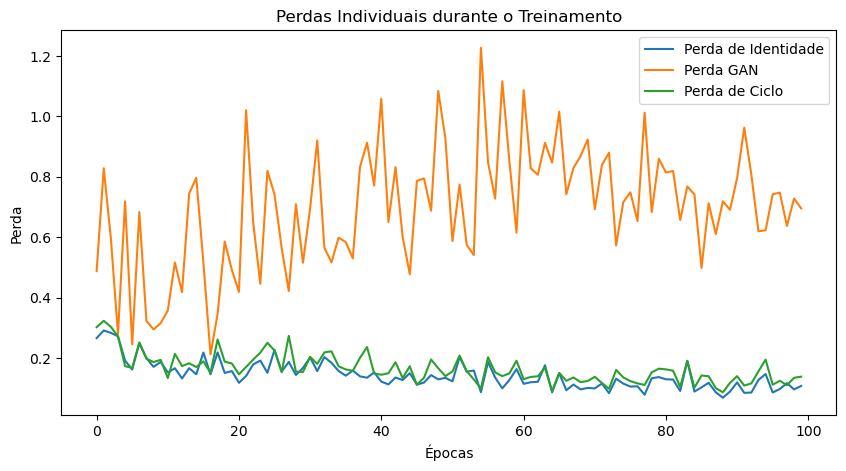

In [24]:
# Plotando as perdas do gerador e dos discriminadores
plt.figure(figsize=(10,5))
plt.title("Perdas do Gerador e Discriminadores durante o Treinamento")
plt.plot(G_losses, label="Perda do Gerador")
plt.plot(D_losses, label="Perda do Discriminador")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.grid()
plt.legend()
plt.savefig('LA.png')
plt.show()

# Plotando as perdas de identidade, GAN e ciclo
plt.figure(figsize=(10,5))
plt.title("Perdas Individuais durante o Treinamento")
plt.plot(identity_losses, label="Perda de Identidade")
plt.plot(GAN_losses, label="Perda GAN")
plt.plot(cycle_losses, label="Perda de Ciclo")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.grid()
plt.legend()
plt.savefig('LI.png')
plt.show()

In [ ]:
def split_into_patches(data, patch_size=256, vertical_overlap=0, horizontal_overlap=0):
    # Splitting 1024x768 matrices into 256x256 patches and storing their positions
    patches = []
    positions = []
    step_h = patch_size - horizontal_overlap
    step_v = patch_size - vertical_overlap
    for i in range(0, data.shape[0] - patch_size + 1, step_v):
        for j in range(0, data.shape[1] - patch_size + 1, step_h):
            patch = data[i:i+patch_size, j:j+patch_size]
            if patch.shape == (patch_size, patch_size):
                patches.append(patch)
                positions.append((i, j))  # Store positions as (row, col)
    return np.array(patches), positions

def reconstruct_from_patches(patches, positions, original_shape, patch_size=256):
    # Reconstruct the original image from patches using stored positions
    reconstructed = np.zeros(original_shape)

    for idx, (patch, (i, j)) in enumerate(zip(patches, positions)):
        # Se o patch ainda for um tensor PyTorch, desconecte-o do grafo computacional e converta para NumPy
        if isinstance(patch, torch.Tensor):
            patch = patch.detach().numpy()  # Detach and convert to NumPy array

        # Remova o canal extra (dimensão 1) se ele existir
        if patch.shape[-1] == 1:
            patch = np.squeeze(patch, axis=-1)
        
        # Coloque o patch de volta na posição original
        reconstructed[i:i+patch_size, j:j+patch_size] = patch

    return reconstructed

# Process the test data
for i, (test_elastic, test_acoustic) in enumerate(zip(dataloader_elastic_train, dataloader_acoustic_train)):

    if i > 1:
        break
        
    test_acustic = test_acustic.squeeze(0).squeeze(0)  # Remove batch dimension
    test_elastic = test_elastic.squeeze(0).squeeze(0)  # Remove batch dimension

    # Split acoustic test data into patches
    patches_elastic, positions = split_into_patches(test_elastic.numpy(), patch_size=256, vertical_overlap=0, horizontal_overlap=151)
    patches_acoustic, positions = split_into_patches(test_acoustic.numpy(), patch_size=256, vertical_overlap=0, horizontal_overlap=151)

    # Pass each acoustic patch through the generator G
    generated_patches_elastic = []
    generated_patches_acoustic = []
    for patch in patches:
        patch_tensor_elastic = torch.tensor(patch_elastic).unsqueeze(0).unsqueeze(0)
        patch_tensor_acoustic = torch.tensor(patch_acoustic).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        patch_tensor_elastic = patch_tensor_elastic.to(device)
        patch_tensor_acoustic = patch_tensor_acoustic.to(device) # Send to GPU if available
        
        generated_patch_elastic = G_AB(patch_tensor_acoustic)
        generated_patch_acoustic = G_BA(patch_tensor_elastic)
        
        generated_patch_elastic = generated_patch_elastic.squeeze(0)
        generated_patch_acoustic = generated_patch_acoustic.squeeze(0)
        generated_patches_elastic.append( generated_patch_elastic)
        generated_patches_acoustic.append(generated_patch_acoustic)

    # Reconstruct the image from the generated patches
    reconstructed_image_elastic = reconstruct_from_patches(generated_patches_elastic, positions, (768, 361), patch_size=256)
    reconstructed_image_acoustic = reconstruct_from_patches(generated_patches_acoustic, positions, (768, 361), patch_size=256)

    # Definir o percentual
    perc = 99
    # Calcular os valores de vmax e vmin com base nos dados
    vmax = np.percentile(np.abs(test_acustic), perc)
    vmin = -vmax

    # Visualize the original acoustic, elastic, and reconstructed image
    plt.figure(figsize=(18, 6))
    
    plt.subplot(2, 2, 1)
    plt.title("eal acoustic")
    plt.imshow(test_elastic, cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.title("Real elastic")
    plt.imshow(test_acosutic, cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.title("Fake elastic")
    plt.imshow(reconstructed_image_elastic, cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.title("Fake acosutic")
    plt.imshow(reconstructed_image_acoustic, cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar()

    plt.savefig('Acoustic to Elastic (Pós-treino) - Cycle')
    plt.show()
    break  # Process only one batch for visualization